# Init

In [97]:
# Import utils
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from plotnine import *
from scipy import stats
import copy
import time
import datetime as dt
import pickle
import pyreadr
import json
import pickle
from joblib import dump, load, Parallel, delayed
import os
import wandb

In [98]:
# Setup
evaluation_setup = {

    'home_dir': '/home/fesc/dddex',
    'results_dir': './Data/Results/WandB',
    'plot_dir': './Plots',
    
    # Experiment data sets:
    'Bakery': 'Bakery',
    'M5': 'M5',
    'SID': 'SID'

}

# Make available
locals().update(evaluation_setup)

# Set working directory
os.chdir(home_dir)

# Download latest results from Weights & Biases

In [ ]:
# Login and connect
wandb.login()
api = wandb.Api()

In [ ]:
# Get artifacts
costData_Bakery = api.artifact('d3wue/modelling'+Bakery+'/costData:latest')
costData_M5 = api.artifact('d3wue/modelling'+M5+'/costData:latest')
costData_SID = api.artifact('d3wue/modelling'+SID+'/costData:latest')

decisionData_Bakery = api.artifact('d3wue/modelling'+Bakery+'/decisionData:latest')
decisionData_M5 = api.artifact('d3wue/modelling'+M5'+/decisionData:latest')
decisionData_SID = api.artifact('d3wue/modelling'+SID+'/decisionData:latest')

In [ ]:
# Download
costData_Bakery.download(root=results_dir+'/'+Bakery+'/costData')
costData_M5.download(root=results_dir+'/'+M5+'/costData')
costData_SID.download(root=results_dir+'/'+SID+'/costData')

decisionData_Bakery.download(root=results_dir+'/'+Bakery+'/decisionData')
decisionData_M5.download(root=results_dir+'/'+M5+'/decisionData')
decisionData_SID.download(root=results_dir+'/'+SID+'/decisionData')

# Pre-process results

In [99]:
def aggregate_results(path, remove_files=False, save_results=True, **kwargs):
    
    # Get all files and combine to one data set
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    results = pd.DataFrame()

    for file in files:
        
        if file.endswith(".pkl"):

            with open(path+'/'+file, 'rb') as f:
                results_ = pickle.load(f).reset_index()

            results_['model'] = file.replace('.pkl', '')

            results = pd.concat([results, results_])

    # Extract service level
    results['sl'] = results['decisionType'].astype('string').apply(
        lambda s: int(s.replace('quantile_', '')) / 1000
    )

    # Extract coefficient of prescriptiveness
    results['coPres'] = results['costs']
    
    # Remove all files
    if(remove_files):
        
        for file in files:
            
            if file.endswith(".pkl"):

                os.remove(path+'/'+file)
    
    # Save
    if(save_results):
        
        results.to_csv(path+'/results.csv', sep=',', index=False)
        
    return results

In [100]:
results_Bakery = aggregate_results(path=results_dir+'/'+Bakery+'/costData')
results_M5 = aggregate_results(path=results_dir+'/'+M5+'/costData')
#results_SID = aggregate_results(path=results_dir+'/'+SID+'/costData')

# Evaluate performance

In [101]:
def plotCoPres(data, figsize=(9,4), dotsize=2, display=0.95, **kwargs):

    if len(data.model.unique()) > 5:
        print('Max number of models exceeded (limited to 5 models)')
        return None
    
    # Model colors
    colors = ['blue', 'black', 'red', 'green', 'yellow']
    positions = [0,1,2,3,4]
    
    # Sepcify limits showing at least 'upper' percent of data
    ylim_top = data.groupby(['sl', 'model']).agg(q = ('coPres', lambda x: np.quantile(x, display))).reset_index().q.max()
    ylim_bottom = data.coPres.min()*0.66

    # Initialize figure / sub-plots
    fig, axes = plt.subplots(ncols=len(data.sl.unique()), sharey=True)
    fig.subplots_adjust(wspace=0)

    # Create and iterate over sub-plots (per service level)
    for ax, sl in zip(axes, data.sl.unique()):

        # Volins (per model)
        vp = ax.violinplot([data.coPres[(data.sl==sl) & (data.model==model)] for model in data.model.unique()], 
                           positions=[positions[i] for i in range(len(data.model.unique()))], showextrema=False)

        # Dots (per model)
        dp = sns.swarmplot(ax=ax, x='model', y='coPres', hue='model', data=data.loc[data.sl==sl], 
                           size=dotsize, alpha=0.33, palette=[colors[i] for i in range(len(data.model.unique()))])
        
        # Boxplots (per model)
        bp = ax.boxplot(x=[data.coPres[(data.sl==sl) & (data.model==model)] for model in data.model.unique()],
                        positions=[positions[i] for i in range(len(data.model.unique()))], 
                        medianprops={'color': 'black', 'linewidth': 2.5}, 
                        widths=0.33, showfliers=False, showcaps=False, whis=0, patch_artist=True)

        # Baseline (per model)
        ax.axhline(y=1, linewidth=1, linestyle='--', color='grey')

        # Color coding for violins and boxplots
        for i in range(len(data.model.unique())):

            # Violins
            vp['bodies'][i].set_facecolor('grey')

            # Boxplots
            bp['boxes'][i].set_color(colors[i])
            bp['boxes'][i].set_facecolor([0,0,0,0])
            #bp['whiskers'][i].set_color(colors[i])
            #bp['caps'][i].set_color(colors[i])
            bp['medians'][i].set_color(colors[i])


        # Remove x-axis ticks
        ax.tick_params(
            axis='x',          
            which='both',      
            bottom=False,      
            labelbottom=False) 

        # Set axis inner axis titles
        ax.set_xlabel(xlabel='{:.2f}'.format(sl))
        ax.set_ylabel(ylabel='normalized cost', fontsize=10, fontweight='bold')
        ax.xaxis.set_label_position('bottom')
        ax.label_outer()

        # Set limits
        ax.set_ylim(bottom=ylim_bottom, top=ylim_top)

        # Add margin
        ax.margins(0.05) 

        # Remove legends per sub-plot
        ax.get_legend().remove()


    # Add figure legend    
    #fig.legend(
    #    [bp['boxes'][i] for i in range(len(data.model.unique()))], 
    #    data.model.unique(), 
    #    loc=(0.444,0.79)
    #)
    
    fig.legend(
        [bp['boxes'][i] for i in range(len(data.model.unique()))], 
        data.model.unique(), 
        bbox_to_anchor=[0.5, 0.95], 
        loc='center', ncol=len(data.model.unique())
    )
    
    

    # Add figure sub-title (below)
    plt.title('Service level', fontsize=10, fontweight='bold', x=-2.5, y=-0.175)

    # Set size
    fig.set_size_inches(figsize)

    # Show plot
    plt.show()

    return fig

## Plot

In [102]:
models = [
    
    'LSx_LGBM_combinedCV_SLTuning', 
    'LSx_NN_LGBM_combinedCV_SLTuning', 
    'WSAA_RF_SLTuning'
    
]

sls = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]

In [103]:
## Bakery

In [104]:
plotData = results_Bakery.loc[results_Bakery.model.isin(models) & results_Bakery.sl.isin(sls)]

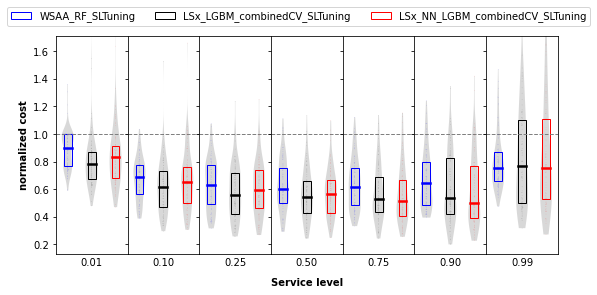

In [105]:
plot = plotCoPres(plotData, dotsize=0.5)

In [106]:
plot.savefig(plot_dir+'/Bakery_new.pdf')  

In [107]:
## M5

In [108]:
plotData = results_M5.loc[results_M5.model.isin(models) & results_M5.sl.isin(sls)]

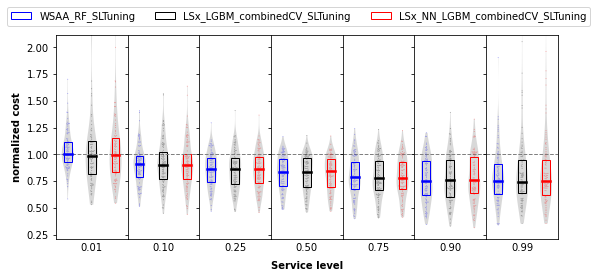

In [109]:
plot = plotCoPres(plotData, dotsize=1, figsize=(9,3.75))

In [110]:
plot.savefig(plot_dir+'/M5_new.pdf')  

## Significance of differences

In [95]:
# TODO

# ***** ARCHIVE *****

**Evaluation Functions**

In [ ]:
class Evaluation:

    def __init__(self):
        
        """
        
        """
        
       

    def get_nv_cost(self, decision, actual, sl):
        
        cost = sl * (actual - decision) * (actual - decision >= 0) + (1-sl) * (decision - actual) * (decision - actual >= 0)
                
        return cost
    
    
    def get_coPres(self, cost, cost_SAA):
    
        """

        Calculates coefficient of prescriptivess defined as cost of model / cost of SAA benchmark model

        Arguments:

            cost: np.array of costs of the model to benchmark
            cost_SAA: np.array of costs of the SAA benchmark model

        Returns:

            coPres: coefficient of prescriptiveness

        """

        coPres = np.mean(cost)/np.mean(cost_SAA)

        return coPres




    def get_mae_naive(self, ts):

        """

        Function to caluclate the MAE of a naive, one-steap ahead forecast of an ordered time series

        Arguments:

            ts: ordered time series

        Values: 

            mae_navie: MAE of a naive, one-steap ahead forecast

        """

        mae_naive = np.mean(abs(ts - ts.shift(1)))


        return mae_naive



    def get_spl(self, p, preds, actuals, mae_naive):

        """

        Function to calculate the Scaled Pinball Loss (SPL) for a traget percentile over predicted and actual test observations, 
        given the MAE of the in-sample naive, one-step ahead forecast

        Arguments:

            p: target percentile
            preds: series of predicted test observations
            actuals: series of actual test observations
            mae_naive: MAE of the in-sample naive, one-step ahead forecast

        Values: 

            spl: Scaled Pinball Loss (SPL)

        """

        pl = np.mean(p * (actuals - preds) * (actuals - preds >= 0) + (1-p) * (preds - actuals) * (preds - actuals >= 0))
        spl = pl / mae_naive

        return spl




    def eval_results(self, data, **kwargs):

        """

        Evaluate Scaled Pinball Loss (SPL) over items and target percentiles in the data provided

        """

        # Set or update defaults
        params = {

            'data_name': '<dataset>',
            'model_name': '<model>',
            'predictions_name': 'quantile_',
            'actuals_name': 'actuals',
            'train_test_label_name': 'label',
            'sort_by': ['id','dayIndex'],
            'dayIndex': 'dayIndex',
            'group_by': ['id'],
            'percentile_denom': 1000

        }  

        params.update(kwargs)

        # Get all percentiles for which results should be obtained
        percentiles = [{'name': i, 'p': int(i.replace(params['predictions_name'], ''))/params['percentile_denom']} 
                       for i in data.columns if i.startswith(params['predictions_name'])]

        # Initialize results
        results = pd.DataFrame()

        # Iterate over all target percentiles and calculate SPL for each item
        for percentile in percentiles:

            result = data.sort_values(params['sort_by']).groupby(params['group_by']).apply(

                lambda df: 

                    pd.Series({

                        'spl':

                            get_spl(p=percentile['p'], 
                                    preds=df[percentile['name']][df[params['train_test_label_name']]=='test'], 
                                    actuals=df[params['actuals_name']][df[params['train_test_label_name']]=='test'], 
                                    mae_naive=get_mae_naive(df[params['actuals_name']][df[params['train_test_label_name']]=='train'])),
                        'p': 
                            percentile['p']

                    })
            ).reset_index()

            results = pd.concat([results,result])

        # Add name of the data set and model
        results['dataset'] = params['data_name']
        results['model'] = params['model_name']

        return results    

**Load data sets and prepare evaluation**

In [ ]:
ev = Evaluation()

**>> Bakery data sets**

In [ ]:
# Load data sets
Bakery_LSF = pd.read_csv('/home/kagu/bakery_results/bakery_LSx_LGBM.csv')
Bakery_LSF_kNN = pd.read_csv('/home/kagu/bakery_results/bakery_LSx_kNN_LGBM.csv')
Bakery_LSF_wkNN= pd.read_csv('/home/kagu/bakery_results/bakery_LSx_kNN_distanceWeights_LGBM.csv')
Bakery_LSF_RF = pd.read_csv('/home/kagu/bakery_results/bakery_LSx_RF.csv')
Bakery_wSAA_RF = pd.read_csv('/home/kagu/bakery_results/bakery_wSAA_RF.csv')
Bakery_SAA = pd.read_csv('/home/kagu/bakery_results/bakery_SAA_perID.csv')

In [ ]:
# Prepare results: LSF
Bakery_LSF_results = pd.wide_to_long(
    Bakery_LSF[Bakery_LSF.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

Bakery_LSF_results['model'] = 'LSF'
Bakery_LSF_results['sl'] = Bakery_LSF_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: LSF kNN
Bakery_LSF_kNN_results = pd.wide_to_long(
    Bakery_LSF_kNN[Bakery_LSF_kNN.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

Bakery_LSF_kNN_results['model'] = 'LSF kNN'
Bakery_LSF_kNN_results['sl'] = Bakery_LSF_kNN_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: LSF w kNN
Bakery_LSF_wkNN_results = Bakery_LSF_wkNN[Bakery_LSF_wkNN.label=='test'][
    ['id', 'dayIndex', 'decisionType', 'decisions', 'actuals']].rename(
    columns={'decisionType': 'sl', 'decisions': 'decision'})

Bakery_LSF_wkNN_results['model'] = 'LSF wkNN'

In [ ]:
# Prepare results: LSF RF
Bakery_LSF_RF_results = Bakery_LSF_RF[Bakery_LSF_RF.label=='test'][
    ['id', 'dayIndex', 'decisionType', 'decisions', 'actuals']].rename(
    columns={'decisionType': 'sl', 'decisions': 'decision'})

Bakery_LSF_RF_results['model'] = 'LSF RF'

In [ ]:
# Prepare results: wSAA RF
Bakery_wSAA_RF_results = pd.wide_to_long(
    Bakery_wSAA_RF[Bakery_wSAA_RF.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

Bakery_wSAA_RF_results['model'] = 'wSAA RF'
Bakery_wSAA_RF_results['sl'] = Bakery_wSAA_RF_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: SAA
Bakery_SAA_results = pd.wide_to_long(
    Bakery_SAA[Bakery_SAA.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

Bakery_SAA_results['model'] = 'SAA'
Bakery_SAA_results['sl'] = Bakery_SAA_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Some consistency checks
sumCheck1 = (
    len(Bakery_LSF.loc[Bakery_LSF.label=='test']),
    len(Bakery_LSF_kNN.loc[Bakery_LSF_kNN.label=='test']),
    len(Bakery_LSF_wkNN.loc[Bakery_LSF_wkNN.label=='test']),
    len(Bakery_LSF_RF.loc[Bakery_LSF_RF.label=='test']),
    len(Bakery_wSAA_RF.loc[Bakery_wSAA_RF.label=='test']),
    len(Bakery_SAA.loc[Bakery_SAA.label=='test'])
)

sumCheck2 = (
    len(Bakery_LSF.loc[Bakery_LSF.label=='test'].id.unique()),
    len(Bakery_LSF_kNN.loc[Bakery_LSF_kNN.label=='test'].id.unique()),
    len(Bakery_LSF_wkNN.loc[Bakery_LSF_wkNN.label=='test'].id.unique()),
    len(Bakery_LSF_RF.loc[Bakery_LSF_RF.label=='test'].id.unique()),
    len(Bakery_wSAA_RF.loc[Bakery_wSAA_RF.label=='test'].id.unique()),
    len(Bakery_SAA.loc[Bakery_SAA.label=='test'].id.unique())
)

sumCheck3 = (
    len(Bakery_LSF.loc[Bakery_LSF.label=='test'].dayIndex.unique()),
    len(Bakery_LSF_kNN.loc[Bakery_LSF_kNN.label=='test'].dayIndex.unique()),
    len(Bakery_LSF_wkNN.loc[Bakery_LSF_wkNN.label=='test'].dayIndex.unique()),
    len(Bakery_LSF_RF.loc[Bakery_LSF_RF.label=='test'].dayIndex.unique()),
    len(Bakery_wSAA_RF.loc[Bakery_wSAA_RF.label=='test'].dayIndex.unique()),
    len(Bakery_SAA.loc[Bakery_SAA.label=='test'].dayIndex.unique())
)

sumCheck4 = (
    len(Bakery_LSF_results.sl.unique()),
    len(Bakery_LSF_kNN_results.sl.unique()),
    len(Bakery_LSF_wkNN_results.sl.unique()),
    len(Bakery_LSF_RF_results.sl.unique()),
    len(Bakery_wSAA_RF_results.sl.unique()),
    len(Bakery_SAA_results.sl.unique())
)

In [ ]:
sumCheck1, sumCheck2, sumCheck3, sumCheck4

In [ ]:
# Combine
Bakery_results = pd.concat([Bakery_LSF_results,
                            Bakery_LSF_kNN_results,
                            Bakery_LSF_wkNN_results,
                            Bakery_LSF_RF_results,
                            Bakery_wSAA_RF_results,
                            Bakery_SAA_results])

In [ ]:
# Get Newsvendor costs per item and test period for each model and SL
Bakery_results['cost'] = ev.get_nv_cost(
    decision=Bakery_results.decision,
    actual=Bakery_results.actuals,
    sl=Bakery_results.sl)
Bakery_results.head()

In [ ]:
# Get coefficient of prescriptiveness per item for each model and sl
Bakery = Bakery_results.loc[Bakery_results.model != 'SAA'].merge(
    Bakery_results.loc[Bakery_results.model == 'SAA'][['sl', 'id', 'dayIndex', 'decision', 'cost']],
    on = ['sl', 'id', 'dayIndex'],
    suffixes = ('', '_SAA')
).groupby(['model', 'sl', 'id']).apply(
    lambda df: 
        pd.Series({
            'coPres': ev.get_coPres(df.cost, df.cost_SAA)
        })).reset_index()

In [ ]:
# Some consistency checks
len(Bakery_results) == 95 * 121 * 105 * 6, len(Bakery) == 95 * 105 * 5

In [ ]:
# Save
Bakery.to_csv( path_or_buf='/home/fesc/LSF/Data/Results/Bakery.csv', sep=',', index=False)

**>> SID data sets**

In [ ]:
# Load data sets
SID_LSF = pd.read_csv('/home/kagu/SID_results/SID_LSF.csv')
SID_LSF_kNN	= pd.read_csv('/home/kagu/SID_results/SID_LSF_kNN.csv')
SID_LSF_RF = pd.read_csv('/home/kagu/SID_results/SID_LSx_RF.csv')
SID_wSAA_RF = pd.read_csv('/home/kagu/SID_results/SID_wSAA_RF.csv')
SID_SAA = pd.read_csv('/home/kagu/SID_results/SID_SAA_perID.csv')

In [ ]:
# Prepare results: LSF
SID_LSF_results = pd.wide_to_long(
    SID_LSF[SID_LSF.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

SID_LSF_results['model'] = 'LSF'
SID_LSF_results['sl'] = SID_LSF_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: LSF kNN
SID_LSF_kNN_results = pd.wide_to_long(
    SID_LSF_kNN[SID_LSF_kNN.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

SID_LSF_kNN_results['model'] = 'LSF kNN'
SID_LSF_kNN_results['sl'] = SID_LSF_kNN_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: LSF RF
SID_LSF_RF_results = SID_LSF_RF[SID_LSF_RF.label=='test'][
    ['id', 'dayIndex', 'decisionType', 'decisions', 'actuals']].rename(
    columns={'decisionType': 'sl', 'decisions': 'decision'})

SID_LSF_RF_results['model'] = 'LSF RF'

In [ ]:
# Prepare results: wSAA RF
SID_wSAA_RF_results = pd.wide_to_long(
    SID_wSAA_RF[SID_wSAA_RF.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'demand']
].rename(columns={'quantile': 'decision', 'demand': 'actuals'})

SID_wSAA_RF_results['model'] = 'wSAA RF'
SID_wSAA_RF_results['sl'] = SID_wSAA_RF_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: SAA
SID_SAA_results = pd.wide_to_long(
    SID_SAA[SID_SAA.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

SID_SAA_results['model'] = 'SAA'
SID_SAA_results['sl'] = SID_SAA_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Some consistency checks
sumCheck1 = (
    len(SID_LSF.loc[SID_LSF.label=='test']),
    len(SID_LSF_kNN.loc[SID_LSF_kNN.label=='test']),
    len(SID_LSF_RF.loc[SID_LSF_RF.label=='test']),
    len(SID_wSAA_RF.loc[SID_wSAA_RF.label=='test']),
    len(SID_SAA.loc[SID_SAA.label=='test'])
)

sumCheck2 = (
    len(SID_LSF.loc[SID_LSF.label=='test'].id.unique()),
    len(SID_LSF_kNN.loc[SID_LSF_kNN.label=='test'].id.unique()),
    len(SID_LSF_RF.loc[SID_LSF_RF.label=='test'].id.unique()),
    len(SID_wSAA_RF.loc[SID_wSAA_RF.label=='test'].id.unique()),
    len(SID_SAA.loc[SID_SAA.label=='test'].id.unique())
)

sumCheck3 = (
    len(SID_LSF.loc[SID_LSF.label=='test'].dayIndex.unique()),
    len(SID_LSF_kNN.loc[SID_LSF_kNN.label=='test'].dayIndex.unique()),
    len(SID_LSF_RF.loc[SID_LSF_RF.label=='test'].dayIndex.unique()),
    len(SID_wSAA_RF.loc[SID_wSAA_RF.label=='test'].dayIndex.unique()),
    len(SID_SAA.loc[SID_SAA.label=='test'].dayIndex.unique())
)

sumCheck4 = (
    len(SID_LSF_results.sl.unique()),
    len(SID_LSF_kNN_results.sl.unique()),
    len(SID_LSF_RF_results.sl.unique()),
    len(SID_wSAA_RF_results.sl.unique()),
    len(SID_SAA_results.sl.unique())
)

In [ ]:
sumCheck1, sumCheck2, sumCheck3, sumCheck4

In [ ]:
# Combine
SID_results = pd.concat([SID_LSF_results, SID_LSF_kNN_results, SID_LSF_RF_results, SID_wSAA_RF_results, SID_SAA_results])

In [ ]:
# Get Newsvendor costs per item and test period for each model and SL
SID_results['cost'] = ev.get_nv_cost(
    decision=SID_results.decision,
    actual=SID_results.actuals,
    sl=SID_results.sl)
SID_results.head()

In [ ]:
# Get coefficient of prescriptiveness per item for each model and sl
SID = SID_results.loc[SID_results.model != 'SAA'].merge(
    SID_results.loc[SID_results.model == 'SAA'][['sl', 'id', 'dayIndex', 'decision', 'cost']],
    on = ['sl', 'id', 'dayIndex'],
    suffixes = ('', '_SAA')
).groupby(['model', 'sl', 'id']).apply(
    lambda df: 
        pd.Series({
            'coPres': ev.get_coPres(df.cost, df.cost_SAA)
        })).reset_index()

In [ ]:
# Some consistency checks
len(SID_results) == 500 * 182 * 105 * 5, len(SID) == 500 * 105 * 4

In [ ]:
# Save
SID.to_csv( path_or_buf='/home/fesc/LSF/Data/Results/SID.csv', sep=',', index=False)

**>> M5 data sets**

In [ ]:
M5_LSF = pd.read_csv('/home/kagu/M5_results/M5_LSF.csv')
M5_LSF_kNN = pd.read_csv('/home/kagu/M5_results/M5_LSF_kNN.csv')
M5_LSF_RF = pd.read_csv('/home/kagu/bakery_results/M5_LSx_RF.csv')
M5_wSAA_RF = pd.read_csv('/home/kagu/M5_results/M5_wSAA_RF.csv')
M5_SAA = pd.read_csv('/home/kagu/M5_results/M5_SAA_perID.csv')

In [ ]:
# Prepare results: LSF
M5_LSF_results = pd.wide_to_long(
    M5_LSF[M5_LSF.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

M5_LSF_results['model'] = 'LSF'
M5_LSF_results['sl'] = M5_LSF_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: LSF kNN
M5_LSF_kNN_results = pd.wide_to_long(
    M5_LSF_kNN[M5_LSF_kNN.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

M5_LSF_kNN_results['model'] = 'LSF kNN'
M5_LSF_kNN_results['sl'] = M5_LSF_kNN_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: LSF RF
M5_LSF_RF_results = M5_LSF_RF[M5_LSF_RF.label=='test'][
    ['id', 'dayIndex', 'decisionType', 'decisions', 'actuals']].rename(
    columns={'decisionType': 'sl', 'decisions': 'decision'})

M5_LSF_RF_results['model'] = 'LSF RF'

In [ ]:
# Prepare results: wSAA RF
M5_wSAA_RF_results = pd.wide_to_long(
    M5_wSAA_RF[M5_wSAA_RF.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

M5_wSAA_RF_results['model'] = 'wSAA RF'
M5_wSAA_RF_results['sl'] = M5_wSAA_RF_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Prepare results: SAA
M5_SAA_results = pd.wide_to_long(
    M5_SAA[M5_SAA.label=='test'], 
    stubnames=['quantile'], 
    i=['id', 'dayIndex'], 
    j='sl', sep='_'
).reset_index()[
    ['id', 'dayIndex', 'sl', 'quantile', 'actuals']
].rename(columns={'quantile': 'decision'})

M5_SAA_results['model'] = 'SAA'
M5_SAA_results['sl'] = M5_SAA_results.sl / 1000 # SL are encoded and need to be brought back to decimal format

In [ ]:
# Some consistency checks
sumCheck1 = (
    len(M5_LSF.loc[M5_LSF.label=='test']),
    len(M5_LSF_kNN.loc[M5_LSF_kNN.label=='test']),
    len(M5_LSF_RF.loc[M5_LSF_RF.label=='test']),
    len(M5_wSAA_RF.loc[M5_wSAA_RF.label=='test']),
    len(M5_SAA.loc[M5_SAA.label=='test'])
)

sumCheck2 = (
    len(M5_LSF.loc[M5_LSF.label=='test'].id.unique()),
    len(M5_LSF_kNN.loc[M5_LSF_kNN.label=='test'].id.unique()),
    len(M5_LSF_RF.loc[M5_LSF_RF.label=='test'].id.unique()),
    len(M5_wSAA_RF.loc[M5_wSAA_RF.label=='test'].id.unique()),
    len(M5_SAA.loc[M5_SAA.label=='test'].id.unique())
)

sumCheck3 = (
    len(M5_LSF.loc[M5_LSF.label=='test'].dayIndex.unique()),
    len(M5_LSF_kNN.loc[M5_LSF_kNN.label=='test'].dayIndex.unique()),
    len(M5_LSF_RF.loc[M5_LSF_RF.label=='test'].dayIndex.unique()),
    len(M5_wSAA_RF.loc[M5_wSAA_RF.label=='test'].dayIndex.unique()),
    len(M5_SAA.loc[M5_SAA.label=='test'].dayIndex.unique())
)

sumCheck4 = (
    len(M5_LSF_results.sl.unique()),
    len(M5_LSF_kNN_results.sl.unique()),
    len(M5_LSF_RF_results.sl.unique()),
    len(M5_wSAA_RF_results.sl.unique()),
    len(M5_SAA_results.sl.unique())
)

In [ ]:
sumCheck1, sumCheck2, sumCheck3, sumCheck4

In [ ]:
# Combine
M5_results = pd.concat([M5_LSF_results, M5_LSF_kNN_results, M5_LSF_RF_results, M5_wSAA_RF_results, M5_SAA_results])

In [ ]:
# Get Newsvendor costs per item and test period for each model and SL
M5_results['cost'] = ev.get_nv_cost(
    decision=M5_results.decision,
    actual=M5_results.actuals,
    sl=M5_results.sl)
M5_results.head()

In [ ]:
# Get coefficient of prescriptiveness per item for each model and sl
M5 = M5_results.loc[M5_results.model != 'SAA'].merge(
    M5_results.loc[M5_results.model == 'SAA'][['sl', 'id', 'dayIndex', 'decision', 'cost']],
    on = ['sl', 'id', 'dayIndex'],
    suffixes = ('', '_SAA')
).groupby(['model', 'sl', 'id']).apply(
    lambda df: 
        pd.Series({
            'coPres': ev.get_coPres(df.cost, df.cost_SAA)
        })).reset_index()

In [ ]:
# Some consistency checks
len(M5_results) == 100 * 28 * 105 * 5, len(M5) == 100 * 105 * 4

In [ ]:
# Save
M5.to_csv( path_or_buf='/home/fesc/LSF/Data/Results/M5.csv', sep=',', index=False)

**>> Yaz data sets**

In [ ]:
Yaz_LSF = pd.read_csv('/home/kagu/yaz_results/yaz_LSx_LGBM_rollingEvaluation.csv')
Yaz_LSF_kNN = pd.read_csv('/home/kagu/yaz_results/yaz_LSx_kNN_LGBM_rollingEvaluation.csv')
Yaz_wSAA_RF = pd.read_csv('/home/kagu/yaz_results/yaz_wSAA_RF_rollingEvaluation.csv')
Yaz_SAA = pd.read_csv('/home/kagu/yaz_results/yaz_SAA_rollingEvaluation.csv')


Yaz_LSF_kNN = Yaz_LSF_kNN.rename(columns={'runId': 'runIndex'})

In [ ]:
# Prepare results: LSF
Yaz_LSF_results = Yaz_LSF[Yaz_LSF.label=='test'][
    ['id', 'dayIndex', 'runIndex', 'decisionType', 'decisions', 'actuals']].rename(
    columns={'decisionType': 'sl', 'decisions': 'decision'})

Yaz_LSF_results['model'] = 'LSF'

In [ ]:
# Prepare results: LSF kNN
Yaz_LSF_kNN_results = Yaz_LSF_kNN[Yaz_LSF_kNN.label=='test'][
    ['id', 'dayIndex', 'runIndex', 'decisionType', 'decisions', 'actuals']].rename(
    columns={'decisionType': 'sl', 'decisions': 'decision'})

Yaz_LSF_kNN_results['model'] = 'LSF kNN'

In [ ]:
# Prepare results: wSAA RF
Yaz_wSAA_RF_results = Yaz_wSAA_RF[Yaz_wSAA_RF.label=='test'][
    ['id', 'dayIndex', 'runIndex', 'decisionType', 'decisions', 'actuals']].rename(
    columns={'decisionType': 'sl', 'decisions': 'decision'})

Yaz_wSAA_RF_results['model'] = 'wSAA RF'

In [ ]:
# Prepare results: SAA
Yaz_SAA_results = Yaz_SAA[Yaz_SAA.label=='test'][
    ['id', 'dayIndex', 'runIndex', 'decisionType', 'decisions', 'actuals']].rename(
    columns={'decisionType': 'sl', 'decisions': 'decision'})

Yaz_SAA_results['model'] = 'SAA'

In [ ]:
# Some consistency checks
sumCheck1 = (
    len(Yaz_LSF.loc[Yaz_LSF.label=='test']),
    len(Yaz_LSF_kNN.loc[Yaz_LSF_kNN.label=='test']),
    len(Yaz_wSAA_RF.loc[Yaz_wSAA_RF.label=='test']),
    len(Yaz_SAA.loc[Yaz_SAA.label=='test'])
)

sumCheck2 = (
    len(Yaz_LSF.loc[Yaz_LSF.label=='test'].id.unique()),
    len(Yaz_LSF_kNN.loc[Yaz_LSF_kNN.label=='test'].id.unique()),
    len(Yaz_wSAA_RF.loc[Yaz_wSAA_RF.label=='test'].id.unique()),
    len(Yaz_SAA.loc[Yaz_SAA.label=='test'].id.unique())
)

sumCheck3 = (
    len(Yaz_LSF.loc[Yaz_LSF.label=='test'].dayIndex.unique()),
    len(Yaz_LSF_kNN.loc[Yaz_LSF_kNN.label=='test'].dayIndex.unique()),
    len(Yaz_wSAA_RF.loc[Yaz_wSAA_RF.label=='test'].dayIndex.unique()),
    len(Yaz_SAA.loc[Yaz_SAA.label=='test'].dayIndex.unique())
)

sumCheck4 = (
    len(Yaz_LSF.loc[Yaz_LSF.label=='test'].runIndex.unique()),
    len(Yaz_LSF_kNN.loc[Yaz_LSF_kNN.label=='test'].runIndex.unique()),
    len(Yaz_wSAA_RF.loc[Yaz_wSAA_RF.label=='test'].runIndex.unique()),
    len(Yaz_SAA.loc[Yaz_SAA.label=='test'].runIndex.unique())
)

sumCheck5 = (
    len(Yaz_LSF_results.sl.unique()),
    len(Yaz_LSF_kNN_results.sl.unique()),
    len(Yaz_wSAA_RF_results.sl.unique()),
    len(Yaz_SAA_results.sl.unique())
)

In [ ]:
sumCheck1, sumCheck2, sumCheck3, sumCheck4, sumCheck5

In [ ]:
# Combine
Yaz_results = pd.concat([Yaz_LSF_results, Yaz_LSF_kNN_results, Yaz_wSAA_RF_results, Yaz_SAA_results])

In [ ]:
# Get Newsvendor costs per item and test period for each model and SL
Yaz_results['cost'] = ev.get_nv_cost(
    decision=Yaz_results.decision,
    actual=Yaz_results.actuals,
    sl=Yaz_results.sl)
Yaz_results.head()

In [ ]:
# Get coefficient of prescriptiveness per item for each model and sl
Yaz = Yaz_results.loc[Yaz_results.model != 'SAA'].merge(
    Yaz_results.loc[Yaz_results.model == 'SAA'][['sl', 'id', 'dayIndex', 'runIndex', 'decision', 'cost']],
    on = ['sl', 'id', 'dayIndex', 'runIndex'],
    suffixes = ('', '_SAA')
).groupby(['model', 'sl', 'id', 'runIndex']).apply(
    lambda df: 
        pd.Series({
            'coPres': ev.get_coPres(df.cost, df.cost_SAA)
        })).reset_index()

In [ ]:
# Some consistency checks
len(Yaz_results) == 7 * 280 * 105 * 4, len(Yaz) == 7 * 20 * 105 * 3

In [ ]:
# Save
Yaz.to_csv( path_or_buf='/home/fesc/LSF/Data/Results/Yaz.csv', sep=',', index=False)

**Evaluate results**

In [ ]:
def evalCoPres(data):

    # Models to compare
    models = data.model.unique()
    
    # Service levels
    sls = data.sl.unique()
    
    # Initialize results
    results = []

    # Iterate over service levels, models, and benchmarks
    for sl in sls:
        for model in models:
            for benchmark in models[models!=model]:

                # Coefficient of prescriptiveness of model and benchmark
                coPres_model = data.loc[(data.sl == sl) & (data.model == model)].coPres
                coPres_benchmark = data.loc[(data.sl == sl) & (data.model == benchmark)].coPres

                result = {

                    # Meta information
                    'sl': sl,
                    'model': model,
                    'benchmark': benchmark,
                    'n': len(coPres_model),

                    # Median coefficient of prescriptiveness
                    'model_median_coPres': np.median(coPres_model),
                    'benchmark_median_coPres': np.median(coPres_benchmark),

                    # Mean coefficient of prescriptiveness
                    'model_mean_coPres': np.mean(coPres_model),
                    'benchmark_mean_coPres': np.mean(coPres_benchmark),

                    # Difference of median (mean) coefficient of prescriptiveness between model and benchmark
                    'difference_median_coPres': np.median(coPres_model) - np.median(coPres_benchmark),
                    'difference_mean_coPres': np.mean(coPres_model) - np.mean(coPres_benchmark),

                    # Median (mean) of differences of coefficient of prescriptiveness between model and benchmark
                    'mean_coPres_difference': np.median(np.array(coPres_model)-np.array(coPres_benchmark)),
                    'median_coPres_difference': np.mean(np.array(coPres_model)-np.array(coPres_benchmark)),

                    # Wilcoxon Signed Rank Sum Test, alternative: distribution of paired differences is stochastically less than a distribution symmetric about zero
                    'pvalue_wilcoxon': stats.wilcoxon(x=coPres_model, y=coPres_benchmark, alternative='less')[1],

                    # Mann-Whitney-U-Test, alternative: distribution underlying x is stochastically less than distribution underlying y
                    'pvalue_mannwhitneyu': stats.mannwhitneyu(x=coPres_model, y=coPres_benchmark, alternative='less')[1],
                    
                    # Share of items where model is better than benchmark
                    'share': sum(coPres_model.values < coPres_benchmark.values) / len(coPres_model),

                }

                results = results + [result]

    # Results data frame
    results = pd.DataFrame(results)
    
    return results

In [ ]:
def plotCoPres(data, **kwargs):
    
    display= kwargs['display'] if 'display' in kwargs else 0.95 
    dotsize= kwargs['dotsize'] if 'dotsize' in kwargs else 2

    if len(data.model.unique()) > 5:
        print('Max number of models exceeded (limited to 5 models)')
        return None
    
    # Model colors
    colors = ['blue', 'black', 'red', 'green', 'yellow']
    positions = [0,1,2,3,4]
    
    # Sepcify limits showing at least 'upper' percent of data
    ylim_top = data.groupby(['sl', 'model']).agg(q = ('coPres', lambda x: np.quantile(x, display))).reset_index().q.max()
    ylim_bottom = data.coPres.min()*0.66

    # Initialize figure / sub-plots
    fig, axes = plt.subplots(ncols=len(target_sl), sharey=True)
    fig.subplots_adjust(wspace=0)

    # Create and iterate over sub-plots (per service level)
    for ax, sl in zip(axes, data.sl.unique()):

        # Volins (per model)
        vp = ax.violinplot([data.coPres[(data.sl==sl) & (data.model==model)] for model in data.model.unique()], 
                           positions=[positions[i] for i in range(len(data.model.unique()))], showextrema=False)

        # Dots (per model)
        dp = sns.swarmplot(ax=ax, x='model', y='coPres', hue='model', data=data.loc[data.sl==sl], 
                           size=dotsize, alpha=0.33, palette=[colors[i] for i in range(len(data.model.unique()))])
        
        # Boxplots (per model)
        bp = ax.boxplot(x=[data.coPres[(data.sl==sl) & (data.model==model)] for model in data.model.unique()],
                        positions=[positions[i] for i in range(len(data.model.unique()))], medianprops={'color': 'black', 'linewidth': 2.5}, 
                        widths=0.33, showfliers=False, showcaps=False, whis=0, patch_artist=True)

        # Baseline (per model)
        ax.axhline(y=1, linewidth=1, linestyle='--', color='grey')

        # Color coding for violins and boxplots
        for i in range(len(data.model.unique())):

            # Violins
            vp['bodies'][i].set_facecolor('grey')

            # Boxplots
            bp['boxes'][i].set_color(colors[i])
            bp['boxes'][i].set_facecolor([0,0,0,0])
            #bp['whiskers'][i].set_color(colors[i])
            #bp['caps'][i].set_color(colors[i])
            bp['medians'][i].set_color(colors[i])


        # Remove x-axis ticks
        ax.tick_params(
            axis='x',          
            which='both',      
            bottom=False,      
            labelbottom=False) 

        # Set axis inner axis titles
        ax.set_xlabel(xlabel='{:.2f}'.format(sl))
        ax.set_ylabel(ylabel='normalized cost', fontsize=10, fontweight='bold')
        ax.xaxis.set_label_position('bottom')
        ax.label_outer()

        # Set limits
        ax.set_ylim(bottom=ylim_bottom, top=ylim_top)

        # Add margin
        ax.margins(0.05) 

        # Remove legends per sub-plot
        ax.get_legend().remove()


    # Add figure legend    
    fig.legend([bp['boxes'][i] for i in range(len(data.model.unique()))], data.model.unique(), loc=(0.444,0.79))

    # Add figure sub-title (below)
    plt.title('Service level', fontsize=10, fontweight='bold', x=-2.5, y=-0.175)

    # Set size
    fig.set_size_inches((6,3.75))

    # Show plot
    plt.show()

    return fig

In [ ]:
# Load results data
Bakery = pd.read_csv('/home/fesc/LSF/Data/Results/Bakery.csv')
SID = pd.read_csv('/home/fesc/LSF/Data/Results/SID.csv')
M5 = pd.read_csv('/home/fesc/LSF/Data/Results/M5.csv')
Yaz = pd.read_csv('/home/fesc/LSF/Data/Results/Yaz.csv')

In [ ]:
# Plot: Bakery
target_sl = [0.01, 0.1, 0.250, 0.500, 0.750, 0.9, 0.99]
data = Bakery.loc[(Bakery.sl.isin(target_sl)) & (Bakery.model.isin(['LSF', 'wSAA RF']))]
plotBakery = plotCoPres(data, dotsize=2.3)
evalBakery = evalCoPres(data)

In [ ]:
# Save
plotBakery.savefig("/home/fesc/LSF/Plots/Bakery.pdf", dpi=300, bbox_inches='tight')

In [ ]:
# See evaluation results
evalBakery.head(5)

In [ ]:
# Plot: Bakery
target_sl = [0.01, 0.1, 0.250, 0.500, 0.750, 0.9, 0.99]
data = Bakery.loc[(Bakery.sl.isin(target_sl)) & (Bakery.model.isin(['LSF', 'LSF kNN', 'LSF wkNN', 'wSAA RF']))]
plotBakery = plotCoPres(data, dotsize=1)
evalBakery = evalCoPres(data)

In [ ]:
# Save
plotBakery.savefig("/home/fesc/LSF/Plots/Bakery2.pdf", dpi=300, bbox_inches='tight')

In [ ]:
# See evaluation results
evalBakery.head(5)

In [ ]:
# Plot: SID
target_sl = [0.01, 0.1, 0.250, 0.500, 0.750, 0.9, 0.99]
data = SID.loc[(SID.sl.isin(target_sl)) & (SID.model.isin(['LSF', 'wSAA RF']))]
plotSID = plotCoPres(data, dotsize=0.66)
evalSID = evalCoPres(data)

In [ ]:
# Save
plotSID.savefig("/home/fesc/LSF/Plots/SID.pdf", dpi=300, bbox_inches='tight')

In [ ]:
# See evaluation results
evalSID.head(5)

In [ ]:
# Plot: M5
target_sl = [0.01, 0.1, 0.250, 0.500, 0.750, 0.9, 0.99]
data = M5.loc[(M5.sl.isin(target_sl)) & (M5.model.isin(['LSF', 'wSAA RF']))]
plotM5 = plotCoPres(data, dotsize=2.3)
evalM5 = evalCoPres(data)

In [ ]:
# Save
plotM5.savefig("/home/fesc/LSF/Plots/M5.pdf", dpi=300, bbox_inches='tight')

In [ ]:
# See evaluation results
evalM5.head(5)

In [ ]:
# Plot: Yaz
target_sl = [0.01, 0.1, 0.250, 0.500, 0.750, 0.9, 0.99]
data = Yaz.loc[(Yaz.sl.isin(target_sl)) & (Yaz.model.isin(['LSF', 'wSAA RF']))]
plotYaz = plotCoPres(data, dotsize=0.66)
evalYaz = evalCoPres(data)

In [ ]:
# Save
plotYaz.savefig("/home/fesc/LSF/Plots/Yaz.pdf", dpi=300, bbox_inches='tight')

In [ ]:
# See evaluation results
evalYaz.head(5)

In [ ]:
## Combine results table
evalBakery['dataset'] = 'Bakery'
evalSID['dataset'] = 'SID'
evalM5['dataset'] = 'M5'
evalYaz['dataset'] = 'Yaz'

Results = pd.concat([evalBakery, evalSID, evalM5, evalYaz])[
    ['dataset', 'n', 'sl', 'model', 'benchmark', 
     'model_median_coPres', 'benchmark_median_coPres', 
     'difference_median_coPres', 'pvalue_mannwhitneyu', 'share']]

# Add significance codes (3=***, 2=**, 1=*, 0)
Results['sig'] = (
    (Results.pvalue_mannwhitneyu < 0.001)*3 + 
    ((Results.pvalue_mannwhitneyu >= 0.001) & (Results.pvalue_mannwhitneyu < 0.01))*2 + 
    ((Results.pvalue_mannwhitneyu >= 0.01) & (Results.pvalue_mannwhitneyu < 0.05))*1 + 
    (Results.pvalue_mannwhitneyu >= 0.05)*0    
)

In [ ]:
# Save
Results.to_csv( path_or_buf='/home/fesc/LSF/Data/Results/Results.csv', sep=',', index=False)

In [ ]:
# Evaluate for LSF vs. wSAA RF
Results = Results.loc[(Results.model == 'LSF') & (Results.benchmark == 'wSAA RF')]

In [ ]:
Results = pd.melt(
    Results, 
    id_vars = ['dataset', 'n', 'sl'], 
    value_vars = ['model_median_coPres',
                  'benchmark_median_coPres',
                  'difference_median_coPres',
                  'pvalue_mannwhitneyu',
                  'sig',
                  'share'], 
    var_name = 'variable',
    value_name = 'value'
)

In [ ]:
Results = Results.pivot(index=['dataset', 'n', 'variable'], columns='sl', values='value')
Results

In [ ]:
# Save
Results.to_csv( path_or_buf='/home/fesc/LSF/Data/Results/Results.csv', sep=',', index=True)

**Archive**

In [ ]:
class NewsvendorSAA:

    def __init__(self, cu = None, co = None,  sl = 0.5):
        
        """
        
        cu: underrage cost
        co: overage cost
        sl: service level defined by cu/(cu+co)
        
        Note: if cu and co are provided, they override sl
        
        """
        
        if (cu == None or co == None):
            
            self.sl = sl
        
        else:
            
            self.sl = cu/(co+cu)

    
    def predict(self, y_train, cu = None, co = None, sl = None):
        
        if (cu == None or co == None):
            
            if sl == None:
            
                sl = self.sl
        
        else: 
            
            sl = cu/(cu+co)
                       
        decision = np.around(np.quantile(y_train, q=sl, method='inverted_cdf'), 4)
        
        return decision
    
    
    def get_cost(self, decision, y_test, cu = None, co = None, sl = None):
        
        if (cu == None or co == None):
            
            if sl == None:
            
                sl = self.sl
        
        else: 
            
            sl = cu/(cu+co)
            
        cost = sl * (y_test - decision) * (y_test - decision >= 0) + (1-sl) * (decision - y_test) * (decision - y_test >= 0)
                
        return cost
    
    
    
    def score(self, y_train, y_test, cu = None, co = None, sl = None):
        
        if (cu == None or co == None):
            
            if sl == None:
            
                sl = self.sl
        
        else: 
            
            sl = cu/(cu+co)
           
        decision = self.predict(y_train=y_train, sl=sl)
        
        cost = self.get_cost(decision=decision, y_test=y_test, sl=sl)
        
        return cost
    
    
    def runExperiment(self, data, sl=[0.25, 0.50, 0.75]):

        results = pd.DataFrame()
        
        for sl_ in sl:
            for i in data.id.unique():

                df = data.loc[data.id==i].sort_values('dayIndex')

                decisions = []
                costs = []

                for dayIndex in df[df.label=='test'].dayIndex:
                    
                    decisions += [
                        nv.predict(y_train=df.loc[df.dayIndex < dayIndex].actuals, 
                                   sl=sl_)
                    ]
                    
                    costs += [
                        nv.score(y_train=df.loc[df.dayIndex < dayIndex].actuals, 
                                 y_test=df.loc[df.dayIndex == dayIndex].actuals.item(), 
                                 sl=sl_)
                    ]


                result = pd.DataFrame({
                    'id': i,
                    'dayIndex': df[df.label=='test'].dayIndex,
                    'sl': sl_,
                    'decision': decisions,
                    'cost': costs
                }, index=None)   


                results = pd.concat([results, result])

        return results

In [ ]:
def plotCoPres(plotData, ylim=(0,2), w=6, h=4, **kwargs):
       
    models = kwargs['models'] if 'models' in kwargs else ['LSF', 'wSAA RF']
    model_names = kwargs['model_names'] if 'model_names' in kwargs else ['LSF', 'wSAA RF']
    model_colors = kwargs['model_colors'] if 'model_colors' in kwargs else ['blue', 'red']
    
    text_size = 7.5
    
    plot = (
        ggplot(plotData)  
        + facet_grid('~sl')
        + aes(x='model', y='coPres', color='model') 
        + geom_violin(width=0.5, color='', fill='lightgrey', alpha=0.66)
        + geom_boxplot(outlier_shape='', coef=0, alpha=0, size=0.5, position=position_dodge(0.99))
        + geom_hline(yintercept=1, color='darkgrey', linetype='dashed', size=0.15) 
        + scale_y_continuous(
            name='coefficient of prescriptiveness',
            breaks=np.arange(0.00, 2.00, 0.1), minor_breaks=[])
        + scale_color_manual(
            name=' ',
            values=model_colors,
            breaks=models,
            labels=model_names)
        #+ coord_cartesian(ylim=ylim)
        + theme_classic()
        + theme(
            axis_title_x=element_blank(),
            axis_text_x=element_blank(),
            axis_ticks_major_x=element_blank(),
            axis_line_x=element_blank(),
            axis_title_y=element_text(face='bold', color='black', size=text_size),
            axis_text_y=element_text(color='black', size=text_size),
            axis_line=element_line(color='black', size=0.15),
            panel_grid=element_blank(),
            #strip_background=element_rect(color='white', size=2, fill='lightgrey', alpha=0.75),
            strip_background=element_blank(),
            strip_text=element_text(face='bold', color='black', size=text_size),
            legend_title=element_text(face='bold', color='black', size=text_size),
            legend_text=element_text(color='black', size=text_size),
            legend_position='bottom',
            legend_direction='horizontal',
            figure_size=(w,h) # width, height
        ) 
    )
    
    return plot